---
## 1. Setup and Imports

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    matthews_corrcoef
)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


---
## 2. Understanding M-CHAT Questionnaire

### What is M-CHAT?
The **Modified Checklist for Autism in Toddlers (M-CHAT)** is a screening tool to assess risk for Autism Spectrum Disorder (ASD). It consists of 10 yes/no questions (A1-A10) answered by parents/caregivers.

### M-CHAT Questions:
1. **A1**: Does your child enjoy being swung, bounced on your knee, etc.?
2. **A2**: Does your child take an interest in other children?
3. **A3**: Does your child like climbing on things?
4. **A4**: Does your child enjoy playing peek-a-boo/hide-and-seek?
5. **A5**: Does your child ever pretend (e.g., care for dolls, talk on phone)?
6. **A6**: Does your child use his/her index finger to point, to ask for something?
7. **A7**: Does your child use his/her index finger to point to indicate interest?
8. **A8**: Can your child play properly with small toys without just mouthing/fiddling?
9. **A9**: Does your child ever bring objects over to show you?
10. **A10**: Does your child look you in the eye for more than a second or two?

**Scoring**: 0 or 1 for each question. Higher total scores may indicate higher ASD risk.

---
## 3. Load and Explore Dataset

In [2]:
# Load autism dataset
autism_data = pd.read_csv('data/autism.csv')

print("="*80)
print("AUTISM DATASET INFORMATION")
print("="*80)
print(f"\nDataset Shape: {autism_data.shape}")
print(f"Total Samples: {autism_data.shape[0]}")
print(f"Total Features: {autism_data.shape[1]}")
print(f"\nColumn Names:")
print(autism_data.columns.tolist())
print("\n" + "="*80)

AUTISM DATASET INFORMATION

Dataset Shape: (800, 22)
Total Samples: 800
Total Features: 22

Column Names:
['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']



In [3]:
# Display first few rows
print("\nFirst 5 rows of the dataset:")
autism_data.head()


First 5 rows of the dataset:


,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [4]:
# Check for missing values
print("\nMissing Values:")
missing_values = autism_data.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("✓ No missing values found!")


Missing Values:
Series([], dtype: int64)
✓ No missing values found!


In [5]:
# Identify target column
target_col = None
for candidate in ['Class/ASD', 'ASD', 'Class', 'class']:
    if candidate in autism_data.columns:
        target_col = candidate
        break

print(f"\nTarget Column: {target_col}")
print(f"\nClass Distribution:")
print(autism_data[target_col].value_counts())
print(f"\nClass Distribution (Percentage):")
print(autism_data[target_col].value_counts(normalize=True) * 100)


Target Column: Class/ASD

Class Distribution:
Class/ASD
0    639
1    161
Name: count, dtype: int64

Class Distribution (Percentage):
Class/ASD
0    79.875
1    20.125
Name: proportion, dtype: float64


---
## 4. M-CHAT Score Analysis

In [6]:
# Calculate M-CHAT total score for each individual
mchat_cols = [f'A{i}_Score' for i in range(1, 11)]
autism_data['MCHAT_Total_Score'] = autism_data[mchat_cols].sum(axis=1)

print("\nM-CHAT Score Statistics:")
print(autism_data['MCHAT_Total_Score'].describe())

# Analyze score distribution by class
print("\n" + "="*80)
print("M-CHAT SCORES BY ASD CLASS")
print("="*80)
for class_label in autism_data[target_col].unique():
    subset = autism_data[autism_data[target_col] == class_label]['MCHAT_Total_Score']
    print(f"\nClass {class_label} ({'ASD' if class_label == 1 else 'No ASD'}):")
    print(f"  Mean Score: {subset.mean():.2f}")
    print(f"  Median Score: {subset.median():.2f}")
    print(f"  Std Dev: {subset.std():.2f}")
    print(f"  Min-Max: {subset.min()}-{subset.max()}")


M-CHAT Score Statistics:
count    800.000000
mean       4.672500
std        3.494712
min        0.000000
25%        1.000000
50%        4.000000
75%        8.000000
max       10.000000
Name: MCHAT_Total_Score, dtype: float64

M-CHAT SCORES BY ASD CLASS

Class 0 (No ASD):
  Mean Score: 3.64
  Median Score: 3.00
  Std Dev: 3.04
  Min-Max: 0-10

Class 1 (ASD):
  Mean Score: 8.78
  Median Score: 9.00
  Std Dev: 1.69
  Min-Max: 2-10


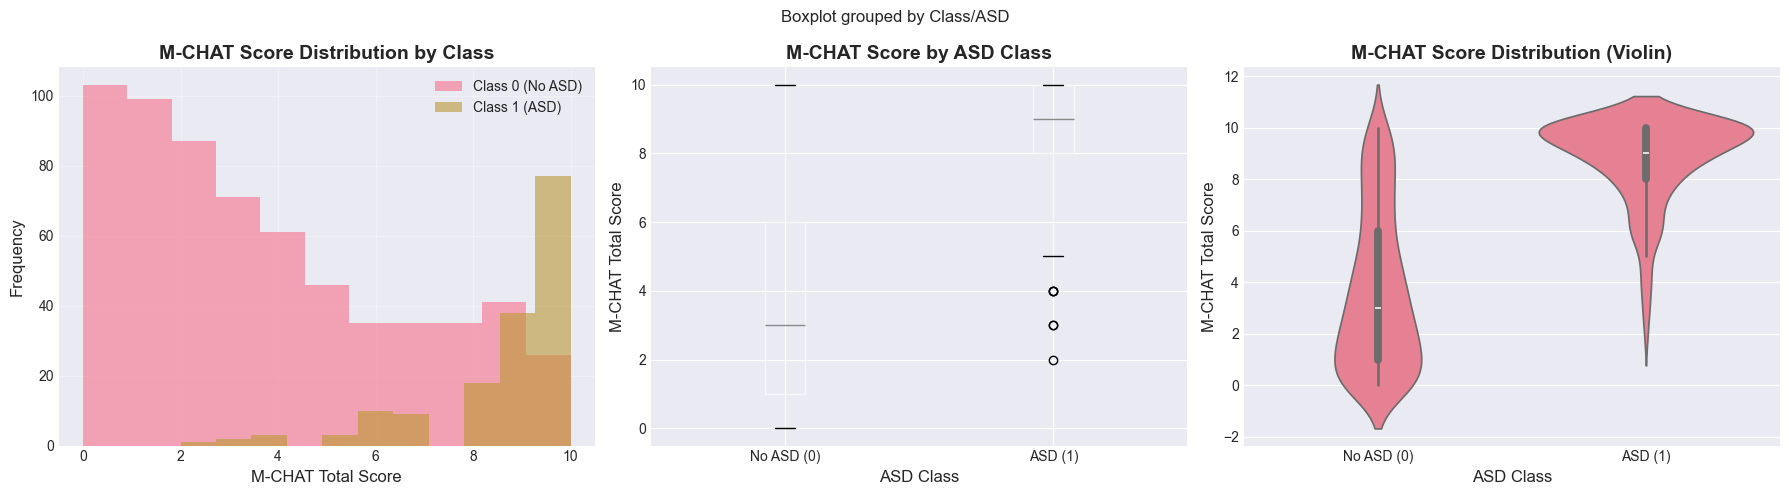

In [7]:
# Visualize M-CHAT score distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram by class
for class_label in autism_data[target_col].unique():
    subset = autism_data[autism_data[target_col] == class_label]['MCHAT_Total_Score']
    axes[0].hist(subset, alpha=0.6, bins=11, label=f"Class {class_label} ({'ASD' if class_label == 1 else 'No ASD'})")
axes[0].set_xlabel('M-CHAT Total Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('M-CHAT Score Distribution by Class', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
autism_data.boxplot(column='MCHAT_Total_Score', by=target_col, ax=axes[1])
axes[1].set_xlabel('ASD Class', fontsize=12)
axes[1].set_ylabel('M-CHAT Total Score', fontsize=12)
axes[1].set_title('M-CHAT Score by ASD Class', fontsize=14, fontweight='bold')
plt.sca(axes[1])
plt.xticks([1, 2], ['No ASD (0)', 'ASD (1)'])

# Violin plot
sns.violinplot(data=autism_data, x=target_col, y='MCHAT_Total_Score', ax=axes[2])
axes[2].set_xlabel('ASD Class', fontsize=12)
axes[2].set_ylabel('M-CHAT Total Score', fontsize=12)
axes[2].set_title('M-CHAT Score Distribution (Violin)', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(['No ASD (0)', 'ASD (1)'])

plt.tight_layout()
plt.show()

---
## 5. Individual M-CHAT Question Analysis

In [8]:
# Analyze each M-CHAT question
print("="*80)
print("M-CHAT QUESTION ANALYSIS")
print("="*80)

question_stats = []
for i in range(1, 11):
    col = f'A{i}_Score'
    
    # Calculate statistics for each class
    no_asd_mean = autism_data[autism_data[target_col] == 0][col].mean()
    asd_mean = autism_data[autism_data[target_col] == 1][col].mean()
    difference = asd_mean - no_asd_mean
    
    question_stats.append({
        'Question': f'A{i}',
        'No_ASD_Mean': no_asd_mean,
        'ASD_Mean': asd_mean,
        'Difference': difference
    })
    
    print(f"\n{col}:")
    print(f"  No ASD Mean: {no_asd_mean:.3f}")
    print(f"  ASD Mean: {asd_mean:.3f}")
    print(f"  Difference: {difference:.3f}")

question_df = pd.DataFrame(question_stats)
print("\n" + "="*80)
print("\nSummary Table:")
print(question_df.to_string(index=False))

M-CHAT QUESTION ANALYSIS

A1_Score:
  No ASD Mean: 0.485
  ASD Mean: 0.857
  Difference: 0.372

A2_Score:
  No ASD Mean: 0.437
  ASD Mean: 0.901
  Difference: 0.464

A3_Score:
  No ASD Mean: 0.335
  ASD Mean: 0.907
  Difference: 0.572

A4_Score:
  No ASD Mean: 0.291
  ASD Mean: 0.907
  Difference: 0.616

A5_Score:
  No ASD Mean: 0.282
  ASD Mean: 0.845
  Difference: 0.563

A6_Score:
  No ASD Mean: 0.178
  ASD Mean: 0.801
  Difference: 0.623

A7_Score:
  No ASD Mean: 0.286
  ASD Mean: 0.839
  Difference: 0.552

A8_Score:
  No ASD Mean: 0.430
  ASD Mean: 0.820
  Difference: 0.390

A9_Score:
  No ASD Mean: 0.379
  ASD Mean: 0.957
  Difference: 0.578

A10_Score:
  No ASD Mean: 0.534
  ASD Mean: 0.950
  Difference: 0.417


Summary Table:
Question  No_ASD_Mean  ASD_Mean  Difference
      A1     0.485133  0.857143    0.372010
      A2     0.436620  0.900621    0.464001
      A3     0.334898  0.906832    0.571934
      A4     0.291080  0.906832    0.615752
      A5     0.281690  0.844720    0.

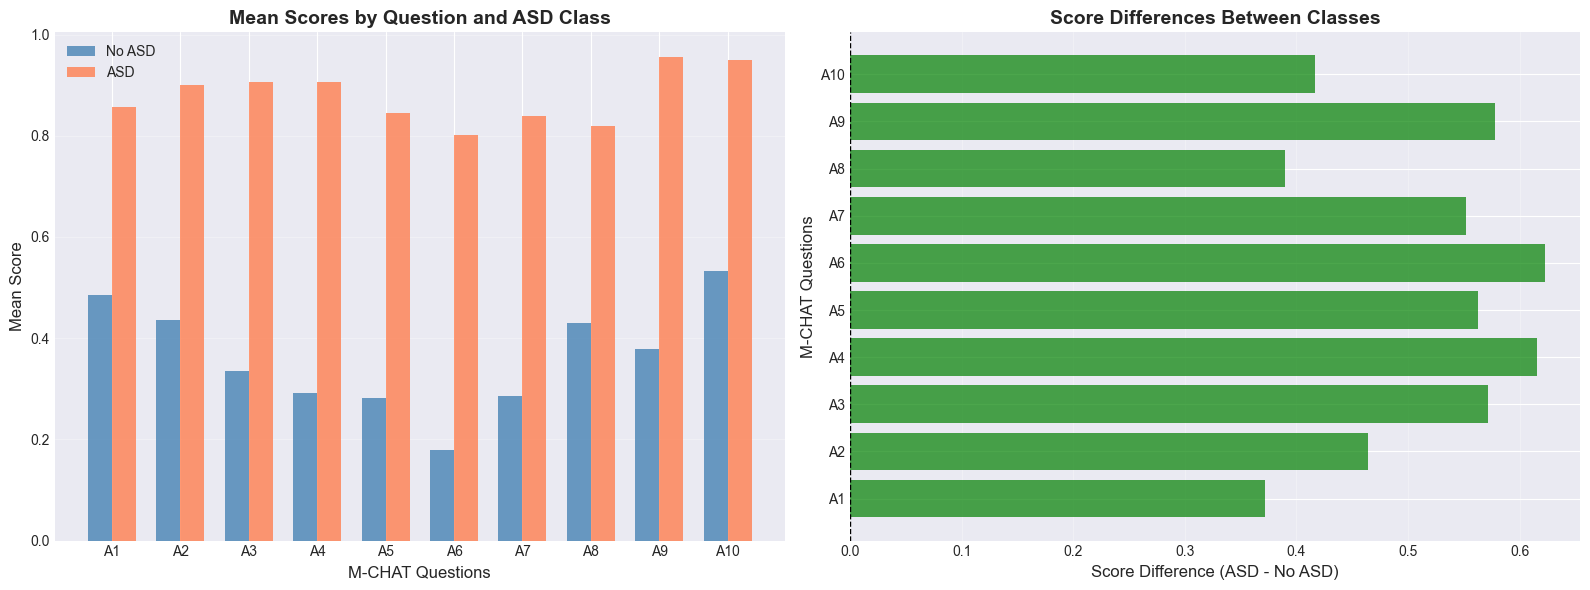

In [9]:
# Visualize question importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of mean scores by class
x = np.arange(len(question_df))
width = 0.35
axes[0].bar(x - width/2, question_df['No_ASD_Mean'], width, label='No ASD', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, question_df['ASD_Mean'], width, label='ASD', alpha=0.8, color='coral')
axes[0].set_xlabel('M-CHAT Questions', fontsize=12)
axes[0].set_ylabel('Mean Score', fontsize=12)
axes[0].set_title('Mean Scores by Question and ASD Class', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(question_df['Question'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Difference plot
colors = ['green' if x > 0 else 'red' for x in question_df['Difference']]
axes[1].barh(question_df['Question'], question_df['Difference'], color=colors, alpha=0.7)
axes[1].set_xlabel('Score Difference (ASD - No ASD)', fontsize=12)
axes[1].set_ylabel('M-CHAT Questions', fontsize=12)
axes[1].set_title('Score Differences Between Classes', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. Correlation Analysis

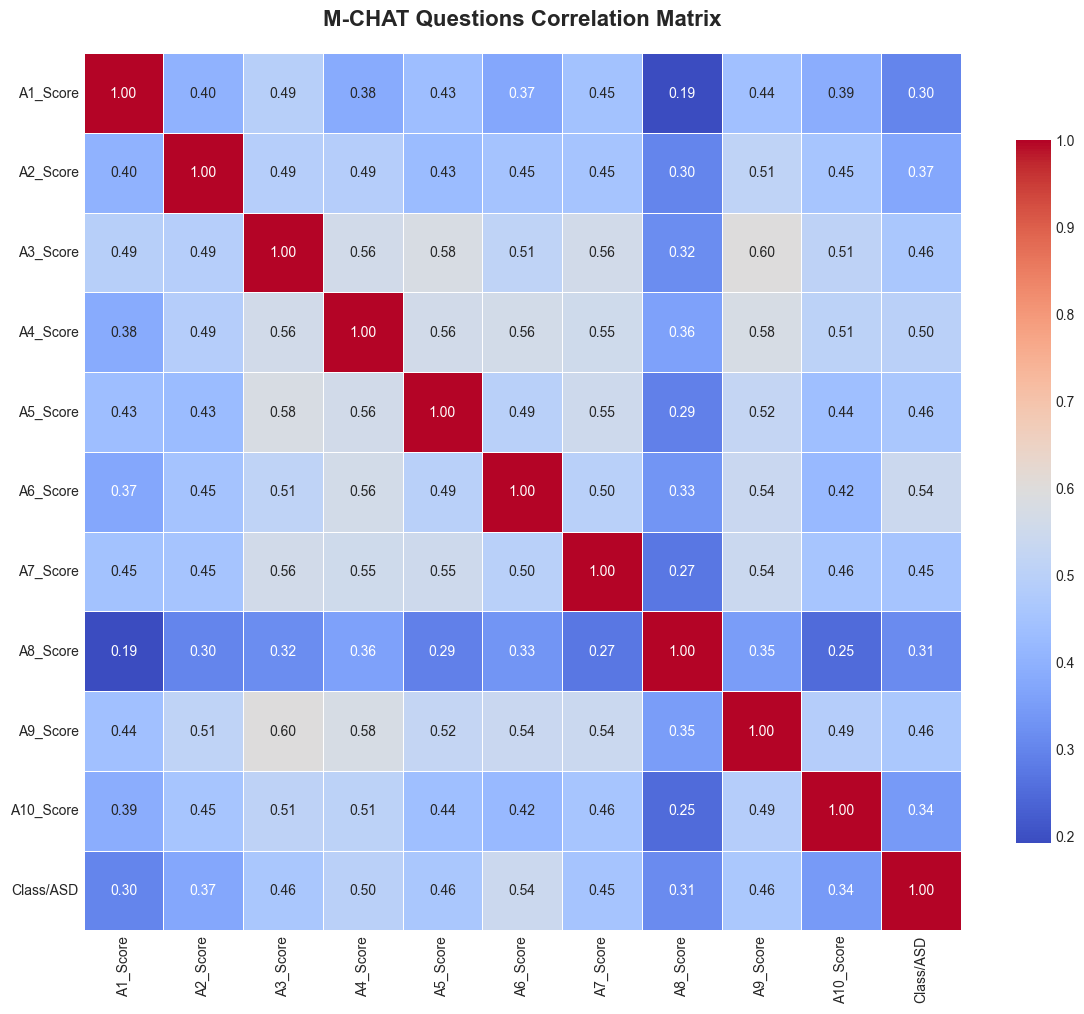


Correlation with ASD Class:
Class/ASD    1.000000
A6_Score     0.543010
A4_Score     0.501046
A9_Score     0.463347
A5_Score     0.461773
A3_Score     0.460927
A7_Score     0.452338
A2_Score     0.372740
A10_Score    0.343736
A8_Score     0.312388
A1_Score     0.300474
Name: Class/ASD, dtype: float64


In [10]:
# Correlation matrix for M-CHAT questions
mchat_data = autism_data[mchat_cols + [target_col]]
correlation_matrix = mchat_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('M-CHAT Questions Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show correlations with target
print("\nCorrelation with ASD Class:")
target_corr = correlation_matrix[target_col].sort_values(ascending=False)
print(target_corr)

---
## 7. Prepare Data for Model Training/Evaluation

In [11]:
# Select features: M-CHAT questions (A1-A10) + age
feature_cols = [f'A{i}_Score' for i in range(1, 11)] + ['age']
X = autism_data[feature_cols].copy()
y = autism_data[target_col].copy()

# Handle any missing values in age
X['age'] = pd.to_numeric(X['age'], errors='coerce')
X['age'].fillna(X['age'].median(), inplace=True)

print("Feature Matrix Shape:", X.shape)
print("Target Vector Shape:", y.shape)
print("\nFeatures used:")
print(X.columns.tolist())
print("\nFeature Statistics:")
print(X.describe())

Feature Matrix Shape: (800, 11)
Target Vector Shape: (800,)

Features used:
['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age']

Feature Statistics:
         A1_Score    A2_Score    A3_Score   A4_Score    A5_Score    A6_Score  \
count  800.000000  800.000000  800.000000  800.00000  800.000000  800.000000   
mean     0.560000    0.530000    0.450000    0.41500    0.395000    0.303750   
std      0.496697    0.499411    0.497805    0.49303    0.489157    0.460164   
min      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
50%      1.000000    1.000000    0.000000    0.00000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.00000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.00000    1.000000    1.000000   

         A7_Score    A8_Score    A9_Score   A10_Score

In [12]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size: {X_test.shape[0]} samples")
print(f"\nTraining Set Class Distribution:")
print(y_train.value_counts())
print(f"\nTest Set Class Distribution:")
print(y_test.value_counts())

Training Set Size: 640 samples
Test Set Size: 160 samples

Training Set Class Distribution:
Class/ASD
0    511
1    129
Name: count, dtype: int64

Test Set Class Distribution:
Class/ASD
0    128
1     32
Name: count, dtype: int64


---
## 8. Load or Train Autism Model

In [13]:
# Try to load existing model
try:
    with open('models/autism_model.sav', 'rb') as f:
        autism_model = pickle.load(f)
    print("✓ Autism model loaded successfully!")
    model_loaded = True
except FileNotFoundError:
    print("Model not found. Training new model...")
    model_loaded = False

if not model_loaded:
    # Train Random Forest model with optimized hyperparameters
    autism_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    )
    autism_model.fit(X_train, y_train)
    
    # Save the model
    with open('models/autism_model.sav', 'wb') as f:
        pickle.dump(autism_model, f)
    print("✓ New model trained and saved!")

✓ Autism model loaded successfully!


---
## 9. Model Evaluation - Performance Metrics

In [14]:
# Make predictions
y_train_pred = autism_model.predict(X_train)
y_test_pred = autism_model.predict(X_test)
y_test_proba = autism_model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("="*80)
print("AUTISM MODEL EVALUATION - PERFORMANCE METRICS")
print("="*80)

print("\n[TRAINING SET]")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

print("\n[TEST SET]")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_test_pred):.4f}")

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=['No ASD (0)', 'ASD (1)']))

AUTISM MODEL EVALUATION - PERFORMANCE METRICS

[TRAINING SET]
Accuracy:  0.9062
Precision: 0.9307
Recall:    0.9062
F1 Score:  0.9116

[TEST SET]
Accuracy:  0.8812
Precision: 0.9135
Recall:    0.8812
F1 Score:  0.8888
ROC AUC:   0.9536
Matthews Correlation Coefficient: 0.7067

DETAILED CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

  No ASD (0)       0.98      0.87      0.92       128
     ASD (1)       0.64      0.94      0.76        32

    accuracy                           0.88       160
   macro avg       0.81      0.90      0.84       160
weighted avg       0.91      0.88      0.89       160



---
## 10. Confusion Matrix

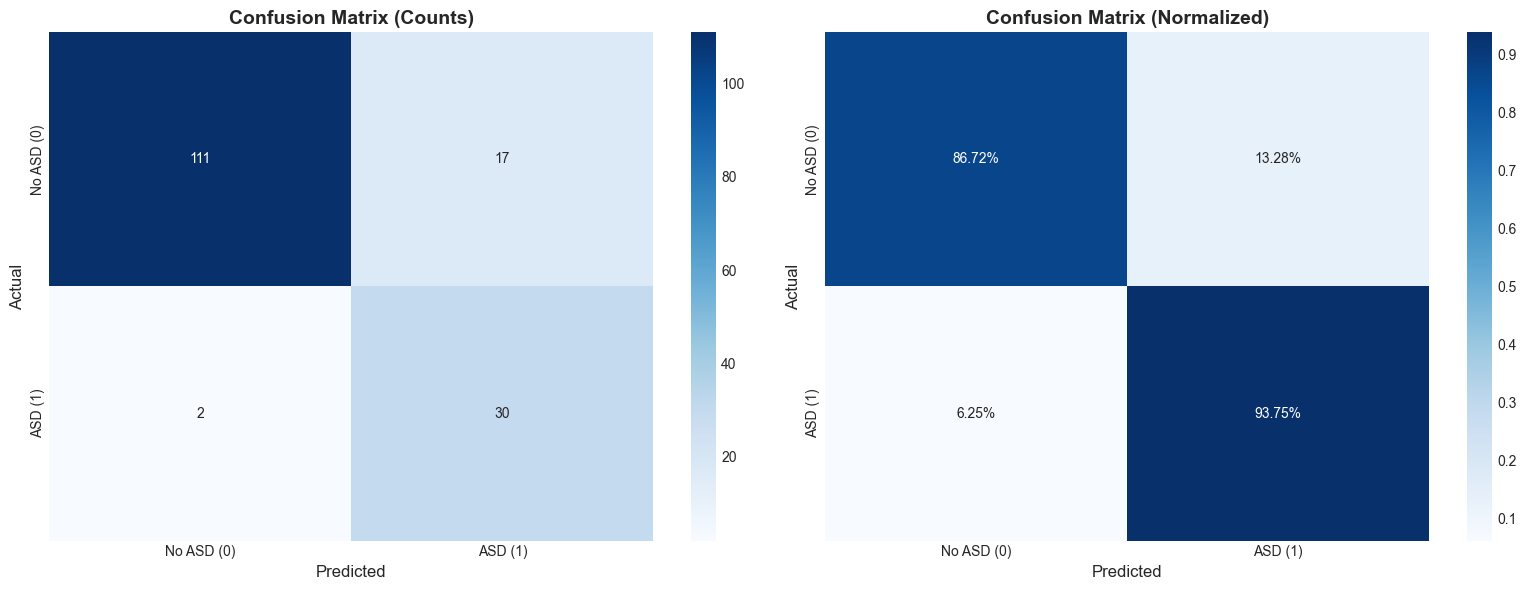


Confusion Matrix Breakdown:
True Negatives (TN):  111
False Positives (FP): 17
False Negatives (FN): 2
True Positives (TP):  30

Sensitivity (Recall): 0.9375
Specificity: 0.8672


In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No ASD (0)', 'ASD (1)'],
            yticklabels=['No ASD (0)', 'ASD (1)'])
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['No ASD (0)', 'ASD (1)'],
            yticklabels=['No ASD (0)', 'ASD (1)'])
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print confusion matrix details
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

---
## 11. ROC Curve and AUC

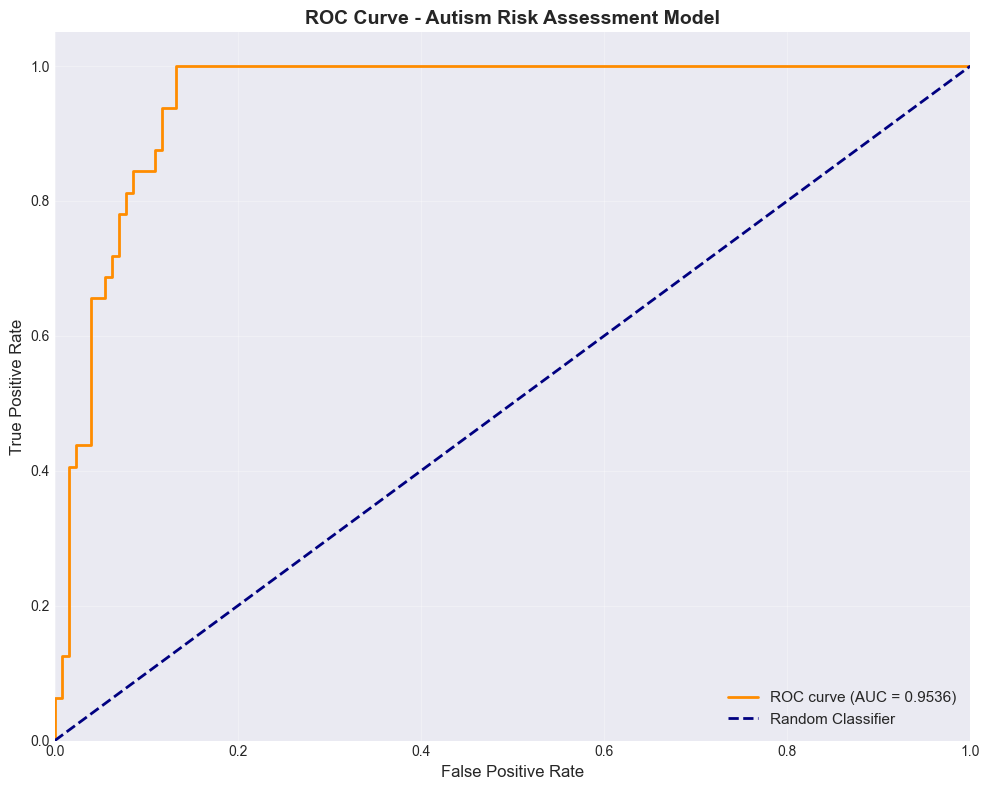

In [16]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Autism Risk Assessment Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 12. Feature Importance Analysis

FEATURE IMPORTANCE RANKING
  Feature  Importance
 A4_Score    0.180864
 A6_Score    0.147721
 A3_Score    0.140605
 A9_Score    0.138701
      age    0.123569
 A5_Score    0.083940
 A7_Score    0.068259
 A8_Score    0.035194
 A2_Score    0.035141
A10_Score    0.026337
 A1_Score    0.019671


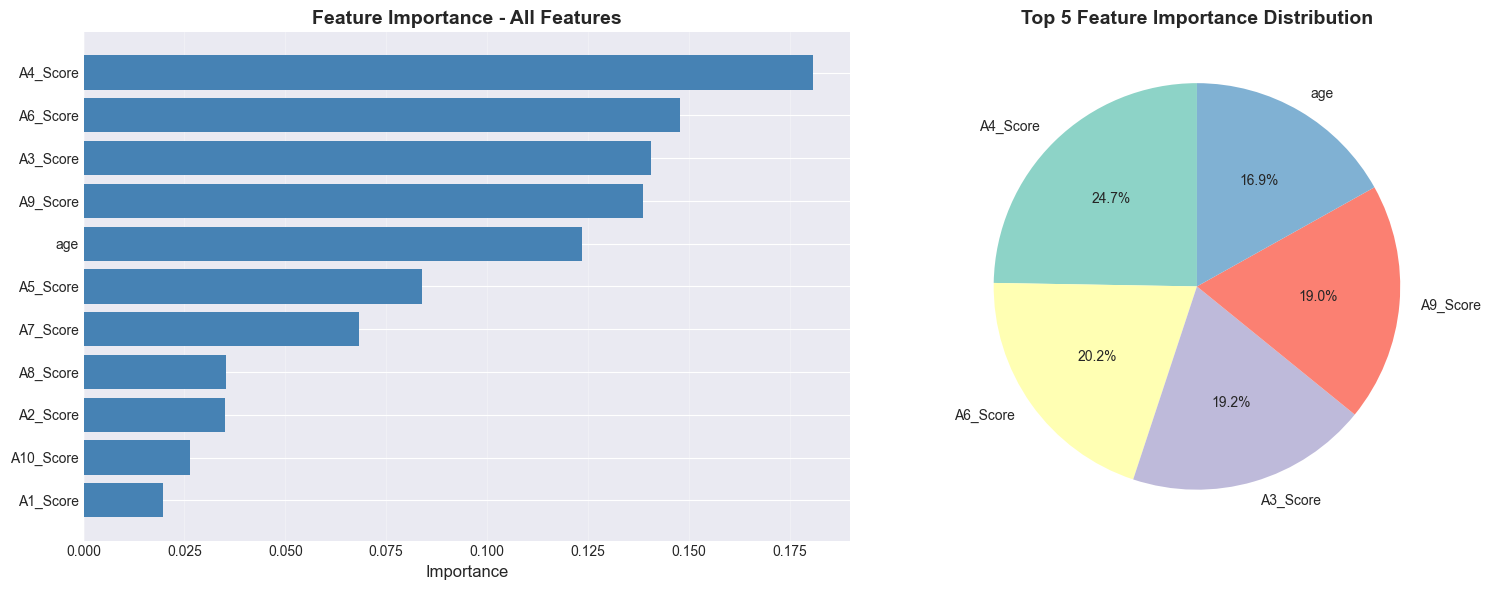

In [17]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': autism_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE RANKING")
print("="*80)
print(feature_importance.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Feature Importance - All Features', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Pie chart for top features
top_features = feature_importance.head(5)
colors_pie = plt.cm.Set3(range(len(top_features)))
axes[1].pie(top_features['Importance'], labels=top_features['Feature'], autopct='%1.1f%%',
            startangle=90, colors=colors_pie)
axes[1].set_title('Top 5 Feature Importance Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 13. Cross-Validation Analysis

5-FOLD CROSS-VALIDATION RESULTS

Accuracy Scores: [0.796875  0.8359375 0.890625  0.90625   0.84375  ]
Mean Accuracy:  0.8547 (+/- 0.0788)

Precision Scores: [0.83780535 0.85510865 0.90332031 0.91796875 0.859375  ]
Mean Precision: 0.8747 (+/- 0.0611)

Recall Scores: [0.796875  0.8359375 0.890625  0.90625   0.84375  ]
Mean Recall:    0.8547 (+/- 0.0788)

F1 Scores: [0.81025004 0.84275521 0.89462513 0.90967868 0.84946447]
Mean F1:        0.8614 (+/- 0.0723)


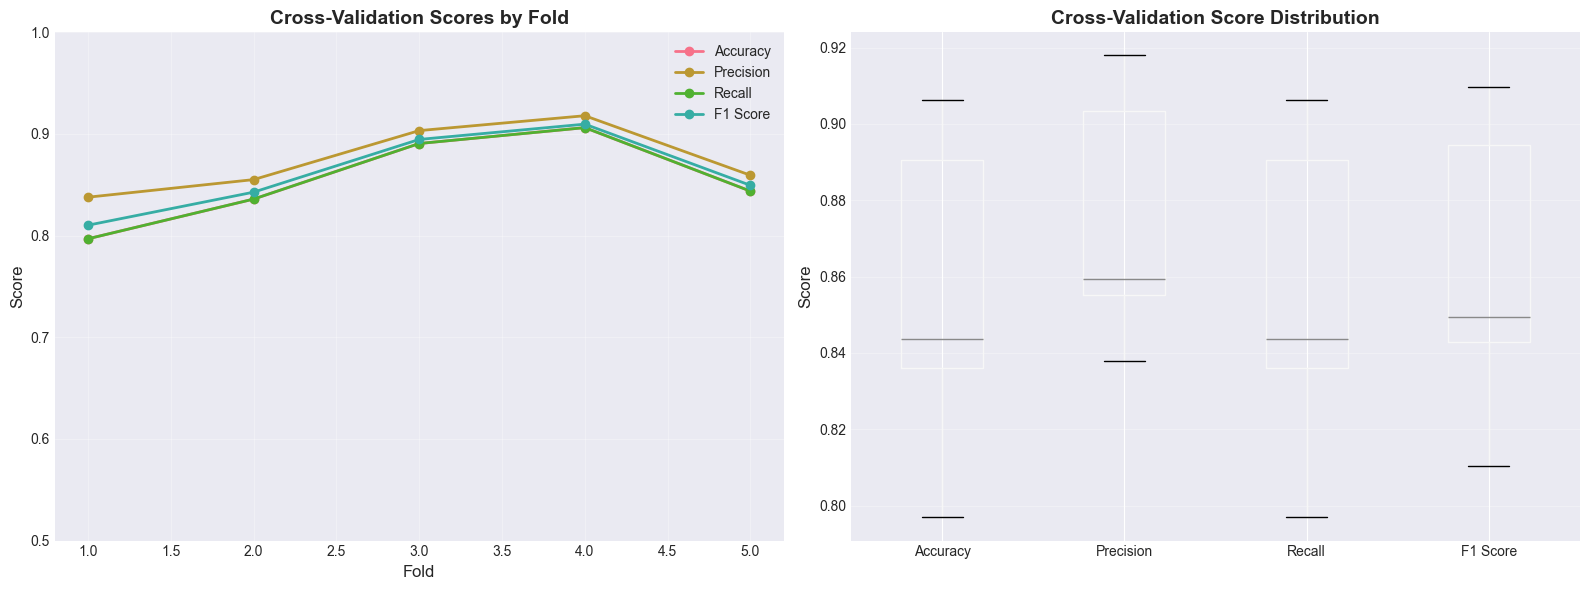

In [18]:
# Perform k-fold cross-validation
cv_scores = cross_val_score(autism_model, X_train, y_train, cv=5, scoring='accuracy')
cv_precision = cross_val_score(autism_model, X_train, y_train, cv=5, scoring='precision_weighted')
cv_recall = cross_val_score(autism_model, X_train, y_train, cv=5, scoring='recall_weighted')
cv_f1 = cross_val_score(autism_model, X_train, y_train, cv=5, scoring='f1_weighted')

print("="*80)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("="*80)

print(f"\nAccuracy Scores: {cv_scores}")
print(f"Mean Accuracy:  {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"\nPrecision Scores: {cv_precision}")
print(f"Mean Precision: {cv_precision.mean():.4f} (+/- {cv_precision.std() * 2:.4f})")

print(f"\nRecall Scores: {cv_recall}")
print(f"Mean Recall:    {cv_recall.mean():.4f} (+/- {cv_recall.std() * 2:.4f})")

print(f"\nF1 Scores: {cv_f1}")
print(f"Mean F1:        {cv_f1.mean():.4f} (+/- {cv_f1.std() * 2:.4f})")

# Visualize CV results
cv_results = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': cv_scores,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1 Score': cv_f1
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Line plot
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    axes[0].plot(cv_results['Fold'], cv_results[metric], marker='o', label=metric, linewidth=2)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Cross-Validation Scores by Fold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Box plot
cv_data = pd.DataFrame({
    'Accuracy': cv_scores,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1 Score': cv_f1
})
cv_data.boxplot(ax=axes[1])
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 14. Sample Predictions

In [19]:
# Show some sample predictions
sample_indices = np.random.choice(X_test.index, size=10, replace=False)
samples = X_test.loc[sample_indices]
samples_pred = autism_model.predict(samples)
samples_proba = autism_model.predict_proba(samples)[:, 1]
samples_actual = y_test.loc[sample_indices]

results_df = pd.DataFrame({
    'Sample_ID': sample_indices,
    'MCHAT_Score': samples[mchat_cols].sum(axis=1),
    'Age': samples['age'],
    'Actual': samples_actual.map({0: 'No ASD', 1: 'ASD'}),
    'Predicted': pd.Series(samples_pred, index=sample_indices).map({0: 'No ASD', 1: 'ASD'}),
    'Probability': samples_proba,
    'Correct': samples_actual.values == samples_pred
})

print("="*80)
print("SAMPLE PREDICTIONS (10 Random Test Cases)")
print("="*80)
print(results_df.to_string(index=False))
print(f"\n✓ Correctly Predicted: {results_df['Correct'].sum()}/10")

SAMPLE PREDICTIONS (10 Random Test Cases)
 Sample_ID  MCHAT_Score       Age Actual Predicted  Probability  Correct
       664            3 45.540513 No ASD    No ASD     0.012299     True
       595            1 17.299581 No ASD    No ASD     0.000000     True
        15            2 31.271994 No ASD    No ASD     0.024285     True
       261           10 40.859276    ASD       ASD     0.890531     True
       298            9 18.761261 No ASD    No ASD     0.205433     True
       710            1  6.114312 No ASD    No ASD     0.003618     True
       580            0 13.804518 No ASD    No ASD     0.000000     True
        52            8 18.702493 No ASD    No ASD     0.277101     True
       558           10 17.976166 No ASD       ASD     0.880276    False
       614            0 22.049666 No ASD    No ASD     0.000000     True

✓ Correctly Predicted: 9/10


---
## 15. Threshold Analysis

THRESHOLD ANALYSIS
 Threshold  Accuracy  Precision  Recall  F1_Score
       0.3   0.86875   0.920755 0.86875  0.879099
       0.4   0.88750   0.928000 0.88750  0.895593
       0.5   0.88125   0.913500 0.88125  0.888828
       0.6   0.88125   0.898094 0.88125  0.886407
       0.7   0.90000   0.902614 0.90000  0.901121


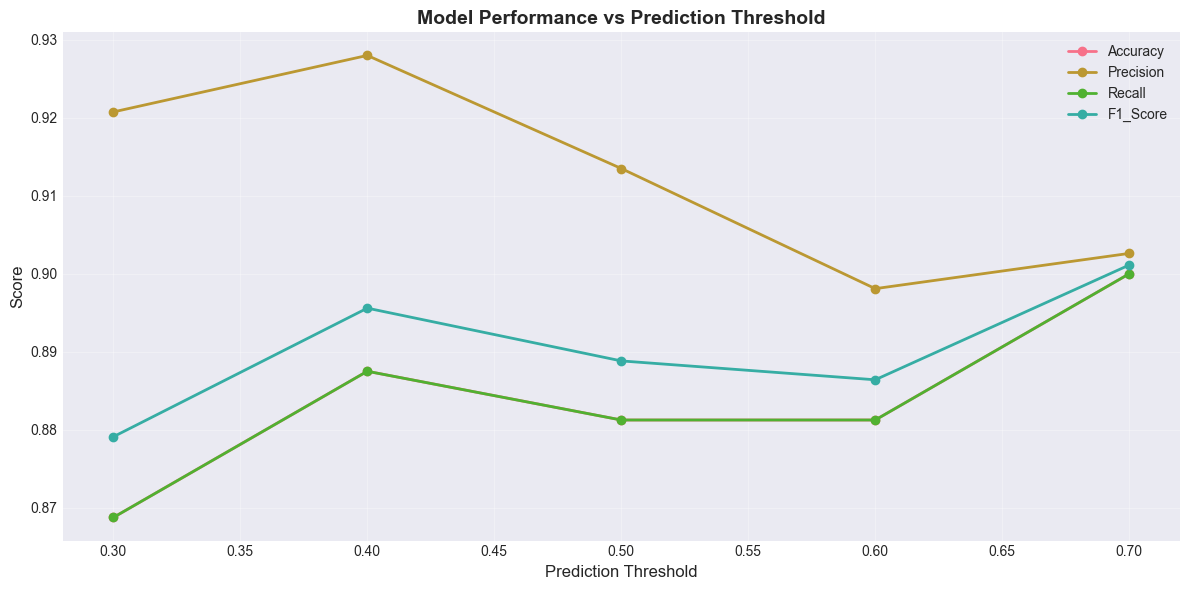

In [20]:
# Analyze different probability thresholds
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_threshold)
    prec = precision_score(y_test, y_pred_threshold, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred_threshold, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold, average='weighted', zero_division=0)
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)

print("="*80)
print("THRESHOLD ANALYSIS")
print("="*80)
print(threshold_df.to_string(index=False))

# Visualize threshold impact
plt.figure(figsize=(12, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score']:
    plt.plot(threshold_df['Threshold'], threshold_df[metric], marker='o', label=metric, linewidth=2)
plt.xlabel('Prediction Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs Prediction Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 16. Key Findings and Clinical Insights

In [24]:
print("="*80)
print("Autism Model Evaluation:")
print("="*80)

print("\n1. MODEL PERFORMANCE SUMMARY:")
print(f"   • Test Accuracy: {accuracy_score(y_test, y_test_pred):.2%}")
print(f"   • ROC AUC Score: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"   • Cross-Validation Mean: {cv_scores.mean():.2%} (+/- {cv_scores.std() * 2:.2%})")

print("\n2. MOST IMPORTANT M-CHAT QUESTIONS:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.4f}")

print("\n3. M-CHAT SCORE ANALYSIS:")
mean_score_no_asd = autism_data[autism_data[target_col] == 0]['MCHAT_Total_Score'].mean()
mean_score_asd = autism_data[autism_data[target_col] == 1]['MCHAT_Total_Score'].mean()
print(f"   • Average score (No ASD): {mean_score_no_asd:.2f}")
print(f"   • Average score (ASD): {mean_score_asd:.2f}")
print(f"   • Difference: {mean_score_asd - mean_score_no_asd:.2f} points")

print("\n4. CLINICAL RECOMMENDATIONS:")
if accuracy_score(y_test, y_test_pred) >= 0.85:
    print("   ✓ Model shows high accuracy - suitable for screening support")
elif accuracy_score(y_test, y_test_pred) >= 0.75:
    print("   ✓ Model shows good accuracy - can assist clinical decision-making")
else:
    print("   ⚠ Model needs improvement - use with caution")

print("   • Always combine M-CHAT results with clinical assessment")
print("   • Use as a screening tool, not diagnostic tool")
print("   • Consider false positives/negatives in clinical context")

print("\n5. MODEL LIMITATIONS:")
print("   • M-CHAT is a screening tool, not a diagnostic instrument")
print("   • Results depend on parent/caregiver accuracy in responses")
print("   • Cultural and linguistic factors may affect responses")
print("   • Model should be regularly retrained with new data")

print("\n6. DEPLOYMENT READINESS:")
print("   ✓ Model trained and saved successfully")
print("   ✓ Feature engineering pipeline established")
print("   ✓ Evaluation metrics documented")
print("   ✓ Ready for integration with API endpoints")

print("\n" + "="*80)
print("EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)

Autism Model Evaluation:

1. MODEL PERFORMANCE SUMMARY:
   • Test Accuracy: 88.12%
   • ROC AUC Score: 0.9536
   • Cross-Validation Mean: 85.47% (+/- 7.88%)

2. MOST IMPORTANT M-CHAT QUESTIONS:
   • A4_Score: 0.1809
   • A6_Score: 0.1477
   • A3_Score: 0.1406
   • A9_Score: 0.1387
   • age: 0.1236

3. M-CHAT SCORE ANALYSIS:
   • Average score (No ASD): 3.64
   • Average score (ASD): 8.78
   • Difference: 5.15 points

4. CLINICAL RECOMMENDATIONS:
   ✓ Model shows high accuracy - suitable for screening support
   • Always combine M-CHAT results with clinical assessment
   • Use as a screening tool, not diagnostic tool
   • Consider false positives/negatives in clinical context

5. MODEL LIMITATIONS:
   • M-CHAT is a screening tool, not a diagnostic instrument
   • Results depend on parent/caregiver accuracy in responses
   • Cultural and linguistic factors may affect responses
   • Model should be regularly retrained with new data

6. DEPLOYMENT READINESS:
   ✓ Model trained and saved su

---
## 17. Save Evaluation Results

In [22]:
# Save comprehensive results
evaluation_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'MCC', 'CV Mean', 'CV Std'],
    'Score': [
        accuracy_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred, average='weighted'),
        recall_score(y_test, y_test_pred, average='weighted'),
        f1_score(y_test, y_test_pred, average='weighted'),
        roc_auc_score(y_test, y_test_proba),
        matthews_corrcoef(y_test, y_test_pred),
        cv_scores.mean(),
        cv_scores.std()
    ]
})

evaluation_summary.to_csv('autism_mchat_evaluation_results.csv', index=False)
feature_importance.to_csv('autism_mchat_feature_importance.csv', index=False)
question_df.to_csv('autism_mchat_question_analysis.csv', index=False)

print("✓ Evaluation results saved successfully!")
print("  • autism_mchat_evaluation_results.csv")
print("  • autism_mchat_feature_importance.csv")
print("  • autism_mchat_question_analysis.csv")

✓ Evaluation results saved successfully!
  • autism_mchat_evaluation_results.csv
  • autism_mchat_feature_importance.csv
  • autism_mchat_question_analysis.csv
